## Курсовой проект

### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = 'C:/Users/Timur/GeekBrains/04.Python_for_DS_p1/Final_project/project/train.csv'
TEST_DATASET_PATH = 'C:/Users/Timur/GeekBrains/04.Python_for_DS_p1/Final_project/project/test.csv'

### Подготовка датасета

#### Описание датасета

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id').sort_values(by=['Id'])
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
0,0,1.00,109.14,84.61,15.00,6,15.00,2011,0.32,B,B,25,4756,16,"2,857.00",5,8,B,"289,034.39"
2,2,1.00,34.47,16.07,5.00,5,18.00,1969,0.00,B,B,33,7425,1,nan,2,5,B,"174,548.97"
5,5,3.00,57.61,38.96,5.00,3,9.00,1974,0.15,B,B,16,3433,4,"2,643.00",4,5,B,"258,091.88"
6,6,1.00,42.47,40.01,1.00,14,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"127,196.76"
10,6,3.00,75.89,78.32,1.00,11,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"218,500.75"


In [5]:
df_train.shape

(10000, 19)

In [6]:
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Id').sort_values(by=['Id'])
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
1,1,2.00,83.06,83.83,0.00,10,22.00,1977,0.01,B,B,1,264,0,nan,0,1,B
3,3,1.00,30.19,14.81,6.00,4,9.00,1970,0.27,B,B,37,5288,0,"1,937.00",3,2,B
4,4,1.00,37.29,17.17,8.00,9,9.00,1970,0.33,B,B,12,2270,23,"2,500.00",1,0,B
8,8,3.00,83.93,50.05,8.00,4,12.00,2007,0.09,B,B,21,4346,2,165.00,1,2,B
9,6,1.00,38.80,42.56,1.00,3,17.00,2017,0.24,B,B,5,1564,0,540.00,0,0,B


In [7]:
df_test.shape

(5000, 18)

### Получаем информацию о данных

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 16798
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Price 

In [9]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [10]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [11]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

DistrictId        0.0
Rooms             0.0
Square            0.0
LifeSquare       21.1
KitchenSquare     0.0
Floor             0.0
HouseFloor        0.0
HouseYear         0.0
Ecology_1         0.0
Ecology_2         0.0
Ecology_3         0.0
Social_1          0.0
Social_2          0.0
Social_3          0.0
##Healthcare_1     48.0
Helthcare_2       0.0
Shops_1           0.0
Shops_2           0.0
Price             0.0

### Обзор данных

Text(0.5, 1.0, 'Price distribution')

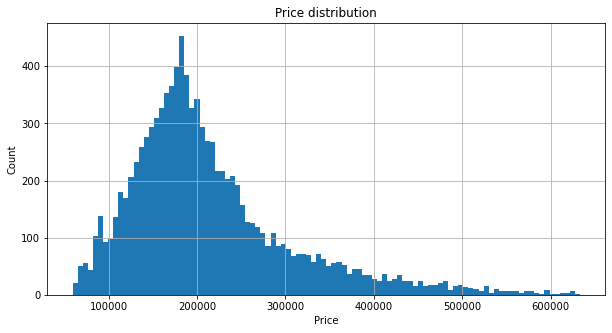

In [12]:
plt.figure(figsize = (10, 5))

df_train['Price'].hist(bins=100)

plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Price distribution')

In [13]:
feature_num_names = df_train.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002090A8D9BE0>,
      dtype=object)

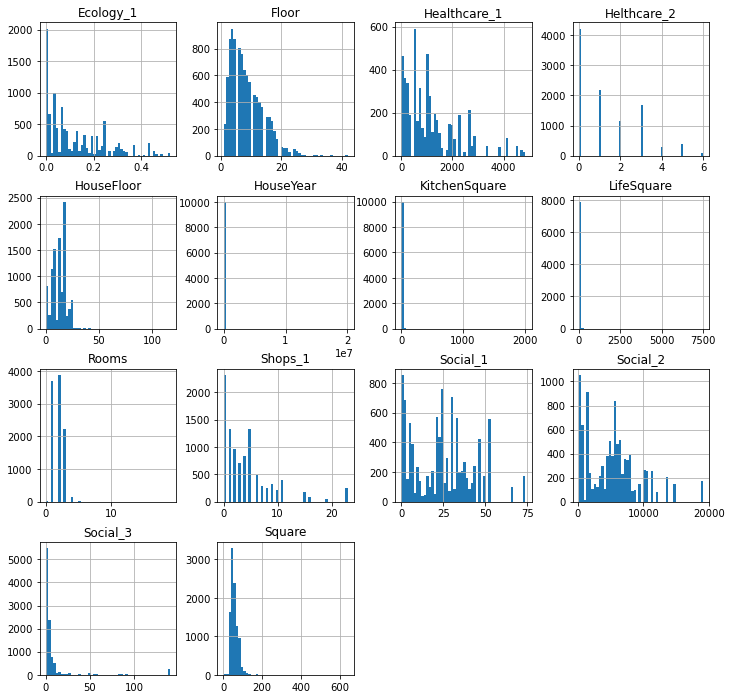

In [14]:
df_train[feature_num_names].hist(figsize=(12,12), bins=50, grid=True)

### Обработка выбросов, ошибок, пропусков

In [15]:
df_train.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### Rooms

In [16]:
df_train['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

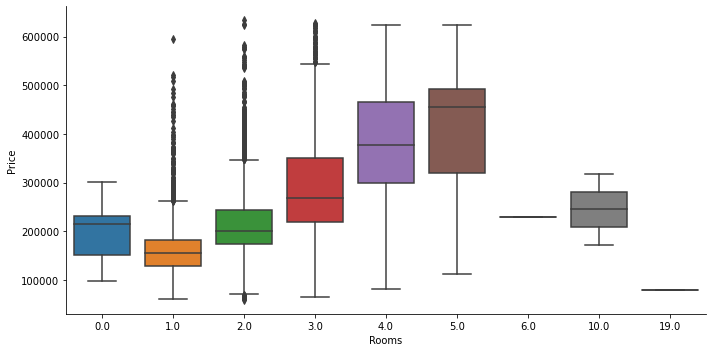

In [17]:
sns.catplot('Rooms', 'Price', kind="box", data=df_train, aspect=2/1);

In [18]:
df_test['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
6.00        2
0.00        2
17.00       1
Name: Rooms, dtype: int64

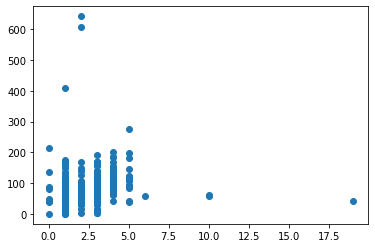

In [19]:
plt.scatter(df_train['Rooms'], df_train['Square']);

In [20]:
df_train.loc[(df_train['Rooms'] > 6), 'Rooms'] = df_train['Rooms'].mode()[0]
df_test.loc[(df_test['Rooms'] > 6), 'Rooms'] = df_train['Rooms'].mode()[0]

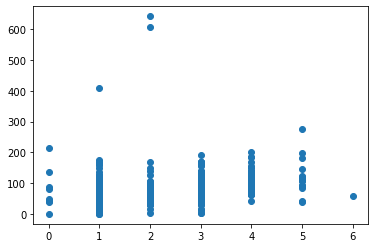

In [21]:
plt.scatter(df_train['Rooms'], df_train['Square']);

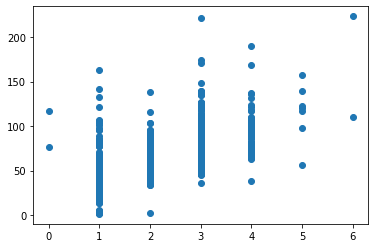

In [22]:
plt.scatter(df_test['Rooms'], df_test['Square']);

#### Square

1. исправить lifesquare в зависимости от кол-ва комнат и года постройки.
2. исправить kitchensquare в завис-ти от square, rooms, year

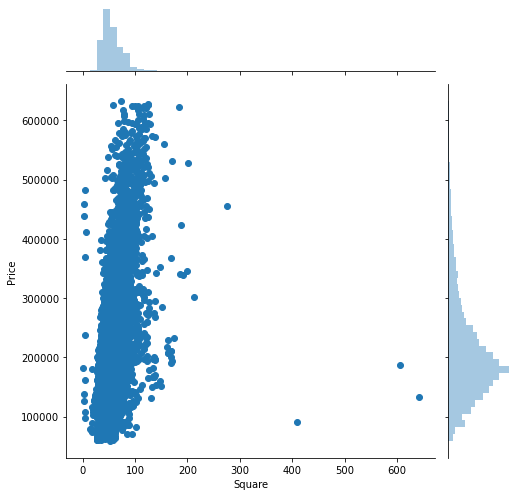

In [23]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=7);

In [24]:
df_train.loc[df_train['Square'] > 300, 'Square'] =\
df_train.groupby(['Rooms', 'HouseYear'])['Square'].transform(lambda x: x.median())

df_test.loc[df_test['Square'] > 300, 'Square'] =\
df_test.groupby(['Rooms', 'HouseYear'])['Square'].transform(lambda x: x.median())

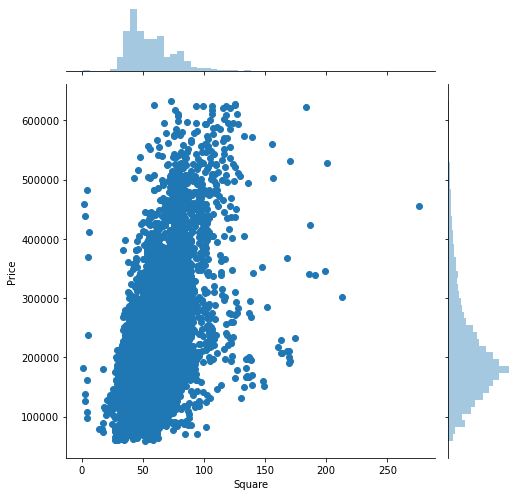

In [25]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=7);

#### Lifesquare, KitchenSquare

In [26]:
df_train.loc[(df_train['LifeSquare'] > df_train['Square']) | (df_train['LifeSquare'].isna()), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10,6,3.00,75.89,78.32,1.00,11,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"218,500.75"
28,9,2.00,63.64,nan,1.00,17,18.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B,"187,717.24"
29,22,3.00,73.93,nan,1.00,4,17.00,1977,0.12,B,B,30,6207,1,"1,183.00",1,0,B,"202,717.17"
32,25,3.00,88.41,nan,1.00,21,25.00,2019,0.07,B,B,53,13670,4,nan,1,11,B,"323,536.77"
41,30,2.00,59.02,59.44,12.00,5,5.00,2016,0.00,B,B,22,6398,141,"1,046.00",3,23,B,"126,281.14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,23,1.00,41.46,nan,1.00,11,17.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,"116,391.10"
16766,58,1.00,49.29,nan,1.00,5,3.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"122,670.47"
16772,109,3.00,32.80,36.66,6.00,2,9.00,1979,0.14,B,B,30,6141,10,262.00,3,6,B,"173,602.71"


In [27]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square']) | (df_test['LifeSquare'].isna()), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
1,1,2.00,83.06,83.83,0.00,10,22.00,1977,0.01,B,B,1,264,0,nan,0,1,B
9,6,1.00,38.80,42.56,1.00,3,17.00,2017,0.24,B,B,5,1564,0,540.00,0,0,B
30,23,2.00,64.42,nan,1.00,8,17.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
54,34,2.00,59.94,nan,1.00,5,1.00,1977,0.07,B,B,53,13670,4,nan,1,11,B
79,27,2.00,67.86,67.87,13.00,4,12.00,2017,0.07,B,B,2,629,1,nan,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16754,33,2.00,45.64,nan,0.00,4,16.00,1977,0.24,B,B,16,3893,27,nan,3,10,B
16756,27,1.00,44.34,nan,1.00,3,1.00,1977,0.07,B,B,2,629,1,nan,0,0,A
16764,1,1.00,41.69,nan,1.00,7,22.00,1977,0.01,B,B,1,264,0,nan,0,1,B


In [28]:
df_train['LfSqr/Sqr'] = np.where((df_train['LifeSquare'] < df_train['Square']) & \
                          (df_train['LifeSquare'].notna()), df_train['LifeSquare'] / \
                           df_train['Square'], None)

df_test['LfSqr/Sqr'] = np.where((df_test['LifeSquare'] < df_test['Square']) & \
                          (df_test['LifeSquare'].notna()), df_test['LifeSquare'] / \
                           df_test['Square'], None)

In [29]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LfSqr/Sqr
Id,,,,,,,,,,,,,,,,,,,,
0,0,1.00,109.14,84.61,15.00,6,15.00,2011,0.32,B,B,25,4756,16,"2,857.00",5,8,B,"289,034.39",0.78
2,2,1.00,34.47,16.07,5.00,5,18.00,1969,0.00,B,B,33,7425,1,nan,2,5,B,"174,548.97",0.47
5,5,3.00,57.61,38.96,5.00,3,9.00,1974,0.15,B,B,16,3433,4,"2,643.00",4,5,B,"258,091.88",0.68
6,6,1.00,42.47,40.01,1.00,14,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"127,196.76",0.94
10,6,3.00,75.89,78.32,1.00,11,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"218,500.75",None


In [30]:
df_train.loc[(df_train['LifeSquare'] > df_train['Square']) | (df_train['LifeSquare'].isna()), 'LifeSquare'] =\
df_train.groupby(['Rooms', 'HouseYear'])['Square'].transform(lambda x: x * df_train['LfSqr/Sqr'].median())

In [31]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square']) | (df_test['LifeSquare'].isna()), 'LifeSquare'] =\
df_test.groupby(['Rooms', 'HouseYear'])['Square'].transform(lambda x: x * df_test['LfSqr/Sqr'].median())

In [32]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LfSqr/Sqr
Id,,,,,,,,,,,,,,,,,,,,
0,0,1.00,109.14,84.61,15.00,6,15.00,2011,0.32,B,B,25,4756,16,"2,857.00",5,8,B,"289,034.39",0.78
2,2,1.00,34.47,16.07,5.00,5,18.00,1969,0.00,B,B,33,7425,1,nan,2,5,B,"174,548.97",0.47
5,5,3.00,57.61,38.96,5.00,3,9.00,1974,0.15,B,B,16,3433,4,"2,643.00",4,5,B,"258,091.88",0.68
6,6,1.00,42.47,40.01,1.00,14,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"127,196.76",0.94
10,6,3.00,75.89,46.34,1.00,11,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,"218,500.75",None


sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6);

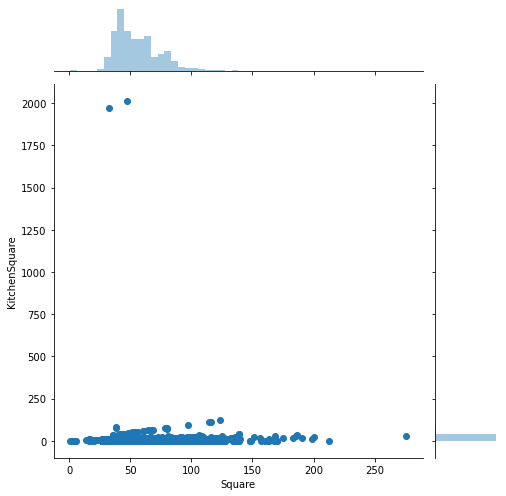

In [33]:
sns.jointplot(df_train['Square'], df_train['KitchenSquare'], kind='scatter', height=7);

In [34]:
df_train.loc[(df_train['KitchenSquare'] > 250) | \
             (df_train['KitchenSquare'] > df_train['Square'] - df_train['LifeSquare']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LfSqr/Sqr
Id,,,,,,,,,,,,,,,,,,,,
58,36,1.00,34.78,33.12,6.00,3,5.00,1961,0.09,B,B,8,1497,5,nan,1,0,B,"146,948.28",0.95
112,6,1.00,41.78,38.40,10.00,12,17.00,2015,0.24,B,B,5,1564,0,540.00,0,0,B,"141,510.64",0.92
247,23,3.00,68.07,67.98,10.00,9,10.00,2014,0.03,B,B,0,168,0,nan,0,0,B,"128,332.77",1.00
251,27,1.00,52.30,45.15,9.00,3,12.00,2019,0.07,B,B,2,629,1,nan,0,0,A,"140,129.28",0.86
287,53,3.00,80.52,79.55,1.00,12,21.00,2016,0.05,B,B,34,7759,0,229.00,1,3,B,"357,335.86",0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16605,23,2.00,55.26,54.97,1.00,5,17.00,2015,0.03,B,B,0,168,0,nan,0,0,B,"112,509.02",0.99
16635,48,2.00,82.89,81.13,10.00,24,25.00,2014,0.04,B,B,46,9515,5,nan,1,10,B,"428,238.09",0.98
16700,27,1.00,40.74,40.15,1.00,9,17.00,2016,0.01,B,B,4,915,0,nan,0,0,B,"109,493.04",0.99


In [35]:
df_train.loc[(df_train['KitchenSquare'] > 150) | (df_train['KitchenSquare'] > df_train['Square'] - df_train['LifeSquare']), \
             'KitchenSquare'] = df_train['Square'] - df_train['LifeSquare']

df_test.loc[(df_test['KitchenSquare'] > 150) | (df_test['KitchenSquare'] > df_test['Square'] - df_test['LifeSquare']), \
             'KitchenSquare'] = df_test['Square'] - df_test['LifeSquare']

In [36]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.17,35.00,5.58
std,19.15,15.29,4.11
min,1.14,0.37,0.00
25%,41.77,23.84,1.00
50%,52.51,32.58,6.00
75%,65.89,43.53,8.00
max,275.65,233.95,58.00


При анализе датасета было выявлено, что значения Healthcare_1 кореллируют со значениями Social_1. Следовательно колонку Healthcare_1 можем исключить из данных.

#### HouseFloor, Floor

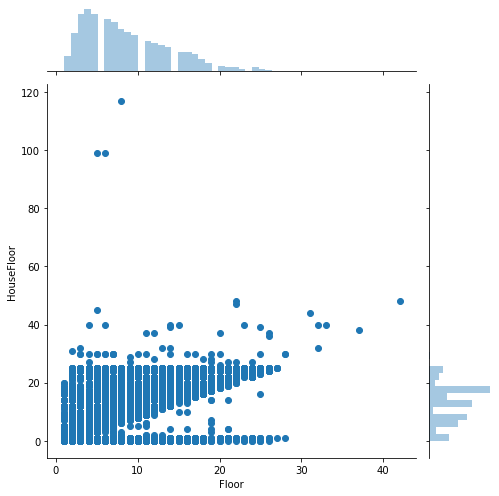

In [37]:
sns.jointplot(df_train['Floor'], df_train['HouseFloor'], kind='scatter', height=7);

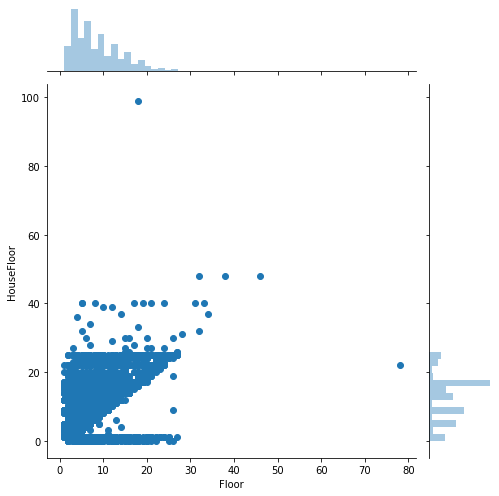

In [38]:
sns.jointplot(df_test['Floor'], df_test['HouseFloor'], kind='scatter', height=7);

In [39]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].mode()[0]
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].mode()[0]

In [40]:
floor_outliers_train = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

floor_outliers_train

Int64Index([   33,    35,    46,    61,    69,    77,    88,    98,   107,
              127,
            ...
            16664, 16674, 16697, 16702, 16711, 16715, 16726, 16753, 16766,
            16785],
           dtype='int64', name='Id', length=1578)

In [41]:
df_train.loc[floor_outliers_train, 'Floor'] = \
    df_train.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
df_test.loc[floor_outliers_test, 'Floor'] = \
    df_test.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### HouseYear

In [42]:
df_train['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
14664        2020
8832         2020
2530         2020
           ...   
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [43]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2011

### Обработка редких категорий

#### DistrictId

In [44]:
print(df_train['DistrictId'].nunique(), ' уникальных  значений в train')
print(df_test['DistrictId'].nunique(), ' уникальных  значений в test')

205  уникальных  значений в train
201  уникальных  значений в test


In [45]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,196,1
201,209,1
202,205,1
203,117,1


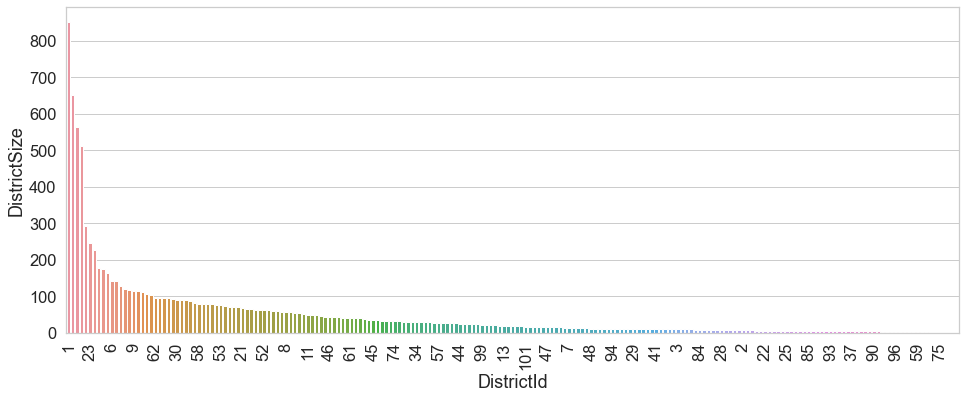

In [46]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [47]:
district_size.loc[district_size['DistrictSize'] > 50, :]

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


In [48]:
district_size_test = df_test['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size_test

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132
...,...,...
196,165,1
197,175,1
198,210,1
199,198,1


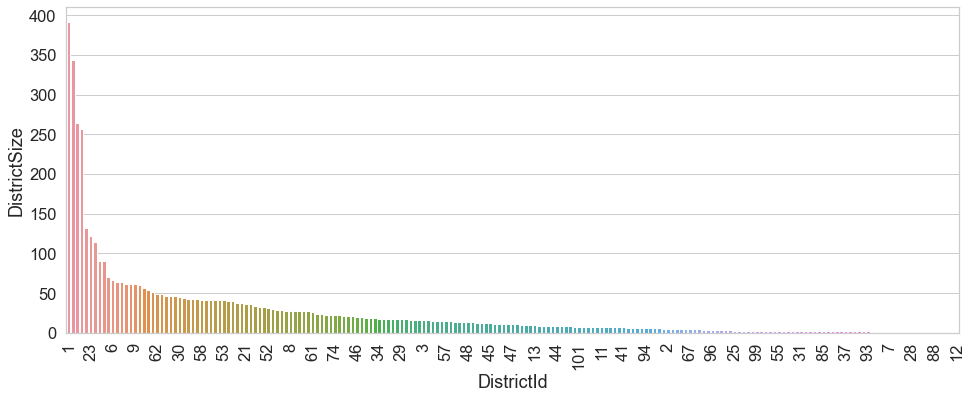

In [49]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size_test,
            order=district_size_test.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [50]:
district_size_test.loc[district_size_test['DistrictSize'] > 50, :]

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132
5,62,122
6,30,115
7,58,91
8,53,91
9,21,70


In [51]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 50, 'DistrictId'].tolist()

In [52]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,999,11
1,1,652
2,10,56
3,101,97
4,105,55
5,11,129
6,12,64
7,128,64
8,13,97
9,17,59


In [53]:
df_train.loc[~df_train['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
df_test.loc[~df_test['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [54]:
df_test['DistrictId'].value_counts()

999    1235
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
8        64
61       64
46       61
34       61
74       61
29       60
3        56
57       54
48       51
47       49
45       49
13       47
101      46
44       46
11       45
41       44
67       43
2        43
94       43
96       42
99       42
25       42
31       41
85       41
55       41
37       40
93       40
28       38
7        38
88       36
12       36
75       34
22       33
26       33
90       30
17       29
39       29
84       28
128      27
66       27
18       26
59       23
105      22
10       16
Name: DistrictId, dtype: int64

### Обработка редких категорий

#### DistrictSize

In [55]:
df_train = df_train.merge(district_size, on='DistrictId', how='left').set_index(df_train.index)
df_test = df_test.merge(district_size, on='DistrictId', how='left').set_index(df_test.index)
df_train.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LfSqr/Sqr,DistrictSize
Id,,,,,,,,,,,,,,,,,,,,,
0,999,1.00,109.14,84.61,15.00,6,15.00,2011,0.32,B,...,25,4756,16,"2,857.00",5,8,B,"289,034.39",0.78,11
2,2,1.00,34.47,16.07,5.00,5,18.00,1969,0.00,B,...,33,7425,1,nan,2,5,B,"174,548.97",0.47,78
5,999,3.00,57.61,38.96,5.00,3,9.00,1974,0.15,B,...,16,3433,4,"2,643.00",4,5,B,"258,091.88",0.68,11
6,6,1.00,42.47,40.01,1.00,14,17.00,2014,0.24,B,...,5,1564,0,540.00,0,0,B,"127,196.76",0.94,511
10,6,3.00,75.89,46.34,1.00,11,17.00,2014,0.24,B,...,5,1564,0,540.00,0,0,B,"218,500.75",None,511
11,9,3.00,76.37,45.67,10.00,14,14.00,1996,0.07,B,...,53,13670,4,nan,1,11,B,"307,799.67",0.60,294
14,12,2.00,57.64,34.43,8.00,17,17.00,1990,0.09,B,...,74,19083,2,nan,5,15,B,"236,258.55",0.60,64
15,13,1.00,46.83,21.76,9.00,6,25.00,2001,0.09,B,...,74,19083,2,nan,5,15,B,"213,389.22",0.46,97
17,9,2.00,60.15,30.07,11.00,6,14.00,1999,0.31,B,...,11,2748,1,nan,0,0,B,"206,431.59",0.50,294


#### PricePerSquare

In [56]:
df_train['PricePerSquare'] = df_train['Price'] / df_train['Square']

#### PricePerSquareByDistrict

In [57]:
price_by_district = df_train.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerSquare':'median'})\
                        .rename(columns={'PricePerSquare':'PricePerSquareByDistrict'})

price_by_district

,DistrictId,PricePerSquareByDistrict
0,999,"4,762.74"
1,1,"3,251.65"
2,10,"4,458.89"
3,101,"4,188.41"
4,105,"4,644.69"
5,11,"4,134.35"
6,12,"4,162.24"
7,128,"4,333.67"
8,13,"4,273.75"
9,17,"5,029.78"


In [58]:
df_train = df_train.merge(price_by_district, on=['DistrictId'], how='left').set_index(df_train.index)
df_test = df_test.merge(price_by_district, on=['DistrictId'], how='left').set_index(df_test.index)

In [59]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LfSqr/Sqr,DistrictSize,PricePerSquare,PricePerSquareByDistrict
Id,,,,,,,,,,,,,,,,,,,,,
0,999,1.00,109.14,84.61,15.00,6,15.00,2011,0.32,B,...,16,"2,857.00",5,8,B,"289,034.39",0.78,11,"2,648.18","4,762.74"
2,2,1.00,34.47,16.07,5.00,5,18.00,1969,0.00,B,...,1,nan,2,5,B,"174,548.97",0.47,78,"5,063.46","4,550.71"
5,999,3.00,57.61,38.96,5.00,3,9.00,1974,0.15,B,...,4,"2,643.00",4,5,B,"258,091.88",0.68,11,"4,480.14","4,762.74"
6,6,1.00,42.47,40.01,1.00,14,17.00,2014,0.24,B,...,0,540.00,0,0,B,"127,196.76",0.94,511,"2,995.20","2,861.08"
10,6,3.00,75.89,46.34,1.00,11,17.00,2014,0.24,B,...,0,540.00,0,0,B,"218,500.75",None,511,"2,879.25","2,861.08"


### Отбор признаков

In [60]:
df_train.to_csv('train_prepared.csv')
df_test.to_csv('test_prepared.csv')

In [61]:
feature_names = df_train.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LfSqr/Sqr',
 'DistrictSize',
 'PricePerSquare',
 'PricePerSquareByDistrict']

In [62]:
target_name = ['Price']
feature_names = [
#             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#             'Ecology_2',
#             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
#             'Healthcare_1',
#             'Helthcare_2',
             'Shops_1',
#             'Shops_2',
#             'Price',
             'DistrictSize',
#             'PricePerSquare',
             'PricePerSquareByDistrict',
#             'RoomSquare'
                ]

In [63]:
X = df_train[feature_names]
y = df_train[target_name]

X_test = df_test[feature_names]

In [64]:
len(feature_names)

13

### Построение модели Random Forest

#### Перекрестная проверка модели

In [65]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=6, 
                               n_estimators=100,
                               random_state=42)

In [66]:
kf = KFold(n_splits=20, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))
# R2: 0.74546 (n_splits=5)
# R2: 0.74805 (n_splits=10)
# R2: 0.74978 (n_splits=20)

R2: 0.74861


#### Важность признаков

In [67]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

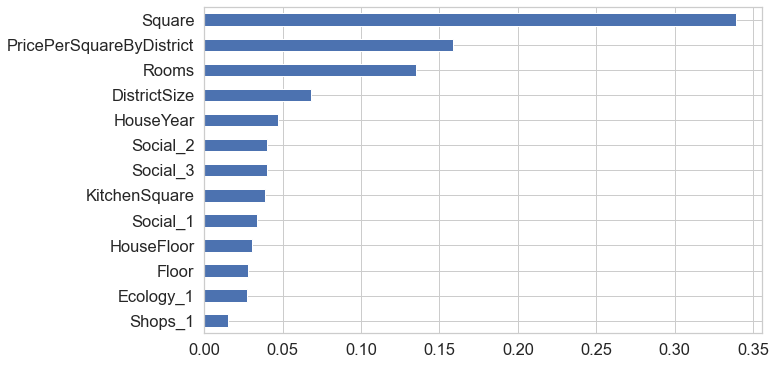

In [68]:
feat_importances.plot(kind='barh', figsize=(10, 6));

### Настройка гиперпараметров модели

In [69]:
params = {
    'n_estimators': [300],
    'max_depth': [15,16,17],
    'max_features': [5,6,7]
}

In [70]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) 
# время обработки 2 мин
# {'max_depth': 16, 'max_features': 5, 'n_estimators': 300}
# R2 на train: 0.75139

{'max_depth': 16, 'max_features': 5, 'n_estimators': 300}
R2 на train: 0.75139


### Прогнозирование на тестовом датасете

In [71]:
forest_best = forest_grid.best_estimator_

y_pred = forest_best.predict(X_test)

In [72]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,1,"255,311.72"
1,3,"147,637.01"
2,4,"211,531.53"
3,8,"324,747.31"
4,9,"129,557.08"


In [73]:
preds.to_csv('TimurEnikeev_predictions.csv', index=False)